In [312]:
import random
from random import sample
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy, truncnorm, kurtosis  # For KL Divergence and truncated normal distribution
from scipy.stats import skew as skewness
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import log_loss
from sklearn.cluster import KMeans
import os

In [313]:
#### load dataset and train logistic regression model

# load dataset
data = load_breast_cancer()
X, y = data.data, data.target

# fit model
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)
gen_model = LogisticRegression()
gen_model.fit(X_scaled,y)

LogisticRegression()

In [314]:
def retrieve_weights_nodes(shape, model, scaler):
    # define a model just to have a model to update
    model_orig = LogisticRegression(max_iter=10000)
    model_orig.coef_ = np.zeros((1, shape[1]))
    model_orig.intercept_ = np.zeros(1)
    model_orig.classes_ = np.array([0, 1])  # Manually set classes
    
    #### Retrieve original model
    # Reshape mean/std
    A = np.zeros(shape)
    B = np.diag(scaler.scale_)
    for j in range(A.shape[1]):
        A[:, j] = scaler.mean_[j]
    
    # Compute original weights
    weights = np.matmul(np.linalg.inv(B), model.coef_.T)
    bias = model.intercept_ - np.matmul(A, weights)[0]
    
    # Update model
    model_orig.intercept_ = bias
    model_orig.coef_ = weights.T

    return model_orig

def get_int(start, end, exclude):
    """Generates a random integer between start and end (inclusive) excluding the 'exclude' number."""
    
    num = random.randint(start, end)
    while num in exclude:
        num = random.randint(start, end)
    return num

def prediction_acc(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [ ]:
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [5]:
#All code put into one function
def full_train(alpha = 0.5, seed=0):
    num_clusters=10
    np.random.seed(seed+1)
    random.seed(seed+1)
    
    # create random guest nodes to use as helpers
    random_helpers = []
    for i in range(num_clusters):
        n1 = get_int(0,num_clusters-1,exclude=[i])
        n2 = get_int(0,num_clusters-1,exclude = [i,n1])
        random_helpers.append([i,n1,n2])

    np.random.seed(seed)
    random.seed(seed)

    #print(random_helpers)
    #### load dataset and train logistic regression model

    # load dataset
    data = load_breast_cancer()
    X, y = data.data, data.target
    
    # fit model
    X_scaler = StandardScaler()
    X_scaled = X_scaler.fit_transform(X)
    gen_model = LogisticRegression()
    gen_model.fit(X_scaled,y)

    #### simulate more data and predict on it to get targets
    # cancer dataset has 569 data, each shift will add this amount of data to the simulation
    num_shifts = 300
    
    # create a list to hold each data shift and targets
    split_data = []
    split_targets = list(list() for _ in range(num_shifts))
    
    
    for _ in range(num_shifts):
        #initialize A
        A = np.zeros(X.shape)
    
        # translation of the columns
        std = np.std(X,axis = 0)
        for j in range(X.shape[1]):
            #use truncated gaussian * std for feature translation
            bounds = [-5,5]
            loc = 0
            scale = 2
            s = truncnorm.rvs((bounds[0]-loc)/scale, (bounds[1]-loc)/scale, loc=loc, scale=scale)
            A[:,j] += s * std[j]
    
        # add gaussian noise with columnwise multiply by std[j]
        B = np.zeros(X.shape)
        for j in range(B.shape[1]):
            B[:,j] += np.random.normal(loc = 0,scale=np.sqrt(0.01), size = B[:,j].shape) * std[j]
    
    
        #split_data.append(A+B)
        split_data.append(X+A+B)
    
    
    # retrieve unnormalized model weights from gen_model
    gen_model_orig = retrieve_weights_nodes(shape=X.shape,model=gen_model,scaler=X_scaler)

    
    # use unnormalized weight prediction probabilities to generate targets
    for i in range(num_shifts):
        for j in range(split_data[i].shape[0]):
            num = np.random.rand()
            pred = gen_model_orig.predict_proba(split_data[i][j,:].reshape(1, -1))[0][1]
            if num < pred:
                split_targets[i].append(int(1))
            else:
                split_targets[i].append(int(0))
    
        
    
    # create the dataset by concatenating all of these shifts into a single numpy array
    full_data = np.concatenate(split_data)
    
    
    # create targets by concatenating all targets into a single numpy array
    full_targets = np.concatenate(split_targets)
    
    # create validation and training data
    val_indices = np.random.choice(full_data.shape[0], size = int(0.2*full_data.shape[0]),replace=False)
    indices = np.array(list(range(full_data.shape[0])))
    data_indices = np.delete(indices,val_indices)
    
    data = full_data[data_indices]
    val_data = full_data[val_indices]
    
    targets = full_targets[data_indices]
    val_targets = full_targets[val_indices]

    #### Find two most important variables using PCA and transform for use in k-means

    # initialize PCA, scale the data and fit/transform data with pca (to both the validation and training)
    pca = PCA(n_components=2)
    data_scaler = StandardScaler()
    data_scaled = data_scaler.fit_transform(data)
    #data_scaled = data
    pca.fit(data_scaled)
    pca_data = pca.transform(data_scaled)

    #### k-means clustering on PCA transformed data
    kmeans = KMeans(n_clusters = num_clusters, max_iter = 1, n_init = "auto").fit(pca_data)
    # check number of data in each cluster
    cluster_labels = kmeans.labels_
    cluster_counts = np.unique(cluster_labels,return_counts=True)
    print(cluster_counts[1])

    #### run pca on validation data and then use the pretrained cluster to place them
    pca_val = PCA(n_components=2)
    val_data_scaler = StandardScaler()
    val_data_scaled = data_scaler.fit_transform(val_data)
    pca_val_data = pca.transform(val_data_scaled)

    # check data in each val cluster
    clustered_val_data = kmeans.predict(pca_val_data)
    val_cluster_counts = np.unique(clustered_val_data,return_counts=True)
    print(val_cluster_counts[1])

    #### create node data and targets grouped by their cluster label
    node_data = [data[cluster_labels==i,:] for i in range(num_clusters)]
    node_targets = [targets[cluster_labels==i] for i in range(num_clusters)]
    
    val_node_data  = [val_data[clustered_val_data==i,:] for i in range(num_clusters)]
    val_node_targets = [val_targets[clustered_val_data==i] for i in range(num_clusters)]

    #### check that all clusters contain both labels
    for i in range(num_clusters):
        print(np.unique(node_targets[i]))
        print(np.unique(val_node_targets[i]))
        if (len(np.unique(node_targets[i])) != 2) or (len(np.unique(val_node_targets[i])) != 2):
            print ("Node Without Both Classes in Train/Val")
            return 1,1,1,1,1,1

    #return 0,0,0,0,0,0
            

    #### compute task distributions (mu,var,skew,kurt) and representatives (since we compute averages here anyway)
    task_distributions = []
    node_representatives = []
    for i in range(num_clusters):
        #print("node " + str(i))
        # class 0
        arr0 = node_data[i][node_targets[i]==0,:]
        n0 = arr0.shape[0]
        #print(n0)
        mean0 = np.mean(arr0, axis=0)
        std0 = np.std(arr0, axis=0)
        skew0 = skewness(arr0, axis=0)
        kurt0 = kurtosis(arr0, axis=0, fisher=True) #excess
        
        #class 1
        arr1 = node_data[i][node_targets[i]==1,:]
        n1 = arr1.shape[0]
        #print(n1)
        mean1 = np.mean(arr1, axis=0)
        std1 = np.std(arr1, axis=0)
        skew1 = skewness(arr1, axis=0)
        kurt1 = kurtosis(arr1, axis=0, fisher=True) #excess 
        
        task_distributions.append([[mean0,std0,skew0,kurt0],[mean1,std1,skew1,kurt1]])
        node_representatives.append([[n0,mean0],[n1,mean1]])

    #### assign task distributions for each node (itself and random two others)
    task_assignments = []
    for i in range(num_clusters):
        n1 = get_int(0,num_clusters-1,exclude=[i])
        n2 = get_int(0,num_clusters-1,exclude = [i,n1])
        task_assignments.append([i,n1,n2])

    # define parameters for node training
    communication_rounds = 100
    local_epochs = 2
    learning_rate = 0.5
    alpha = alpha
    # dimension of the data for calculate w_j's later, n is the total numbers of data in the simulation
    d = X.shape[1]
    n = data.shape[0]
    eps = 0.0001

    #### initialize logistic regression models and StandardScalers for each node
    node_models = [LogisticRegression(max_iter=10000, warm_start=True) for _ in range(num_clusters)]
    #fed_avg_models = [LogisticRegression(max_iter=10000, warm_start=True) for _ in range(num_clusters)]
    local_node_models = [LogisticRegression(max_iter=10000, warm_start=True) for _ in range(num_clusters)]
    constant_node_models = [LogisticRegression(max_iter=10000, warm_start=True) for _ in range(num_clusters)]
    
    # Set all coefficients and intercepts to zero initially and manually set classes_
    for k in range(num_clusters):
        node_models[k].coef_ = np.zeros((1, node_data[k].shape[1]))
        node_models[k].intercept_ = np.zeros(1)
        node_models[k].classes_ = np.array([0, 1])  # Manually set classes
        local_node_models[k].coef_ = np.zeros((1, node_data[k].shape[1]))
        local_node_models[k].intercept_ = np.zeros(1)
        local_node_models[k].classes_ = np.array([0, 1])  # Manually set classes
        constant_node_models[k].coef_ = np.zeros((1, node_data[k].shape[1]))
        constant_node_models[k].intercept_ = np.zeros(1)
        constant_node_models[k].classes_ = np.array([0, 1])  # Manually set classes
        # fed_avg_models[k].coef_ = np.zeros((1, node_data[k].shape[1]))
        # fed_avg_models[k].intercept_ = np.zeros(1)
        # fed_avg_models[k].classes_ = np.array([0, 1])  # Manually set classes
    
    ## fit standardscaler for each of the nodes (used to retrieve unscaled model parameters)
    node_scalers = []
    for k in range(num_clusters):
        node_scaler = StandardScaler()
        node_scaler.fit(node_data[k])
        node_scalers.append(node_scaler)

    #### begin training
    val_preds = [list() for _ in range(num_clusters)] #each node will append a 3-list every communication round
    val_preds_const = [list() for _ in range(num_clusters)]
    val_preds_local = [list() for _ in range(num_clusters)]
    energy_coefs_all = []
    lambdas_all = []
    for t in range(communication_rounds):
    
        #print("===== Communication Round " + str(t+1) + "======\n")
    
        # retrieve unscaled models
        if t != 0:
            unscaled_models = [retrieve_weights_nodes(shape=node_data[i].shape,model=node_models[i],scaler=node_scalers[i])
                              for i in range(num_clusters)]
            unscaled_models_constant = [retrieve_weights_nodes(shape=node_data[i].shape,model=constant_node_models[i],scaler=node_scalers[i])
                              for i in range(num_clusters)]
            
        else:
            unscaled_models = node_models
            unscaled_models_constant = constant_node_models
    
        # compute each node predictions on representatives for node models(we will weight distillation later)
        #(note: node_representatives -> ([[n0,mean0],[n1,mean1]]))
        rep_preds = [list() for _ in range(num_clusters)] #each list will be a node's predictions on all representatives
        # node to predict
        for i in range(num_clusters):
            # reps to predict on
            for j in range(num_clusters):
                #scores
                score0 = np.dot(node_representatives[j][0][1], unscaled_models[i].coef_.flatten()) + unscaled_models[i].intercept_
                score1 = np.dot(node_representatives[j][1][1], unscaled_models[i].coef_.flatten()) + unscaled_models[i].intercept_
                #clip
                score0 = np.clip(score0, -10, 10)
                score1 = np.clip(score1, -10, 10)
                #probabilities/predictions
                prob0 = (1 / (1 + np.exp(-score0)))
                prob1 = (1 / (1 + np.exp(-score1)))
                #save
                rep_preds[i].append([prob0,prob1])

        # compute each node predictions on representatives for CONSTANT node models(we will weight distillation later)
        #(note: node_representatives -> ([[n0,mean0],[n1,mean1]]))
        rep_preds_constant = [list() for _ in range(num_clusters)] #each list will be a node's predictions on all representatives
        # node to predict
        for i in range(num_clusters):
            # reps to predict on
            for j in range(num_clusters):
                #scores
                score0 = np.dot(node_representatives[j][0][1], unscaled_models_constant[i].coef_.flatten()) + unscaled_models_constant[i].intercept_
                score1 = np.dot(node_representatives[j][1][1], unscaled_models_constant[i].coef_.flatten()) + unscaled_models_constant[i].intercept_
                #clip
                score0 = np.clip(score0, -10, 10)
                score1 = np.clip(score1, -10, 10)
                #probabilities/predictions
                prob0 = (1 / (1 + np.exp(-score0)))
                prob1 = (1 / (1 + np.exp(-score1)))
                #save
                rep_preds_constant[i].append([prob0,prob1])
    
        energy_coefficients = [] # each element corresponds to a node and contains a list of H to each task distribution
        # compute H between each node distribution and prediction task distributions
        for i in range(num_clusters):
            # retrieve model parameters
            node_model_orig = retrieve_weights_nodes(shape=node_data[i].shape,model=node_models[i],scaler=node_scalers[i])

            W = np.zeros(d)
            if t != 0:
                # compute feature importance
                q = np.zeros(d)
                q0 = node_model_orig.predict_proba(np.zeros(30).reshape(1,-1))[0][1]
                for j in range(d):
                    z_j = np.zeros(d)
                    z_j[j] = 1
                    q[j] = node_model_orig.predict_proba(z_j.reshape(1,-1))[0][1]
        
                for j in range(d):
                    W[j] = np.abs(q[j] - q0) / (np.sum(np.abs(q - q0)))

            else:
                W = np.ones(d) / d

            # compute approximate distances to every prediction task distribution (class0 and class1)
            approx_distances0 = [np.zeros(d) for _ in range(num_clusters)]
            approx_distances1 = [np.zeros(d) for _ in range(num_clusters)]
            
            for j in range(num_clusters):
                # task_distributions = [] (node -> class -> (mean,var,skew,kurt))
    
                # calculate nu_XY, C_4XY, C_3XY, del_mu1, del_mu2 for class 0
                for k in range(d):
                    nu_XY_0 = (task_distributions[i][0][1][k]**2 + task_distributions[j][0][1][k]**2 + 
                                    (task_distributions[i][0][0][k] - task_distributions[j][0][0][k])**2)
                    
                    C_4XY_0 = ((task_distributions[i][0][1][k]**4)*task_distributions[i][0][3][k] + 
                                     (task_distributions[j][0][1][k]**4)*task_distributions[j][0][3][k])
                    
    
                    C_3XY_0 = ((task_distributions[i][0][1][k]**3)*task_distributions[i][0][2][k] - 
                                  (task_distributions[j][0][1][k]**3)*task_distributions[j][0][2][k])
    
                    del_mu1_0 = (task_distributions[i][0][0][k] - task_distributions[j][0][0][k])
                    del_mu2_0 = ((task_distributions[i][0][0][k] - task_distributions[j][0][0][k])**2)

                    val0 = np.sqrt(nu_XY_0)*( (3/4) - (C_4XY_0 + 4*C_3XY_0*del_mu1_0 - 2*(del_mu2_0**2))/(8*(nu_XY_0**2)))
                    approx_distances0[j][k] = val0
                    
                    nu_XY_1 = (task_distributions[i][1][1][k]**2 + task_distributions[j][1][1][k]**2 + 
                                    (task_distributions[i][1][0][k] - task_distributions[j][1][0][k])**2)
                    
                    C_4XY_1 = ((task_distributions[i][1][1][k]**4)*task_distributions[i][1][3][k] + 
                                     (task_distributions[j][1][1][k]**4)*task_distributions[j][1][3][k])
                    
    
                    C_3XY_1 = ((task_distributions[i][1][1][k]**3)*task_distributions[i][1][2][k] - 
                                  (task_distributions[j][1][1][k]**3)*task_distributions[j][1][2][k])
    
                    del_mu1_1 = (task_distributions[i][1][0][k] - task_distributions[j][1][0][k])
                    del_mu2_1 = ((task_distributions[i][1][0][k] - task_distributions[j][1][0][k])**2)

                    val1 = np.sqrt(nu_XY_1)*( (3/4) - (C_4XY_1 + 4*C_3XY_1*del_mu1_1 - 2*(del_mu2_1**2))/(8*(nu_XY_1**2)))
                    approx_distances1[j][k] = val1

    
            # compute self distances for each prediction task distribution
            self_distances0 = [np.zeros(d) for _ in range(num_clusters)]
            self_distances1 = [np.zeros(d) for _ in range(num_clusters)]
    
            for j in range(num_clusters):
                for k in range(d):
                    nu_XY_0 = (task_distributions[j][0][1][k]**2 + task_distributions[j][0][1][k]**2 + 
                                    (task_distributions[j][0][0][k] - task_distributions[j][0][0][k])**2)
                    
                    C_4XY_0 = ((task_distributions[j][0][1][k]**4)*task_distributions[j][0][3][k] + 
                                     (task_distributions[j][0][1][k]**4)*task_distributions[j][0][3][k])
                    
    
                    C_3XY_0 = ((task_distributions[j][0][1][k]**3)*task_distributions[j][0][2][k] - 
                                  (task_distributions[j][0][1][k]**3)*task_distributions[j][0][2][k])
    
                    del_mu1_0 = (task_distributions[j][0][0][k] - task_distributions[j][0][0][k])
                    del_mu2_0 = ((task_distributions[j][0][0][k] - task_distributions[j][0][0][k])**2)

                    val0 = np.sqrt(nu_XY_0)*( (3/4) - (C_4XY_0 + 4*C_3XY_0*del_mu1_0 - 2*(del_mu2_0**2))/(8*(nu_XY_0**2)))
                    self_distances0[j][k] = val0
                    
                    nu_XY_1 = (task_distributions[j][1][1][k]**2 + task_distributions[j][1][1][k]**2 + 
                                    (task_distributions[j][1][0][k] - task_distributions[j][1][0][k])**2)
                    
                    C_4XY_1 = ((task_distributions[j][1][1][k]**4)*task_distributions[j][1][3][k] + 
                                     (task_distributions[j][1][1][k]**4)*task_distributions[j][1][3][k])
                    
    
                    C_3XY_1 = ((task_distributions[j][1][1][k]**3)*task_distributions[j][1][2][k] - 
                                  (task_distributions[j][1][1][k]**3)*task_distributions[j][1][2][k])
    
                    del_mu1_1 = (task_distributions[j][1][0][k] - task_distributions[j][1][0][k])
                    del_mu2_1 = ((task_distributions[j][1][0][k] - task_distributions[j][1][0][k])**2)

                    val1 = np.sqrt(nu_XY_1)*( (3/4) - (C_4XY_1 + 4*C_3XY_1*del_mu1_1 - 2*(del_mu2_1**2))/(8*(nu_XY_1**2)))
                    self_distances1[j][k] = val1
    
            # # compute H0 and H1 using w_i's
            H0 = []
            H1 = []
            for j in range(num_clusters):
                val0 = 0
                val1 = 0
                for k in range(d):
                    val0 += W[k]*((2*approx_distances0[j][k] - self_distances0[i][k] - self_distances0[j][k]) / (2*approx_distances0[j][k]))
                    val1 += W[k]*((2*approx_distances1[j][k] - self_distances1[i][k] - self_distances1[j][k]) / (2*approx_distances1[j][k]))
                H0.append(val0)
                H1.append(val1)
            
            H = []
            n0_temp = node_representatives[i][0][0]
            n1_temp = node_representatives[i][1][0]  
            for j in range(num_clusters):
                H.append((n0_temp*H0[j] + n1_temp*H1[j]) / (n0_temp + n1_temp))
                
            # save list of H's
            energy_coefficients.append(H)
            #print(H)
        energy_coefs_all.append(energy_coefficients)
        # compute lambdas using assigned task distributions + all nodes and update model parameters (training)
        lambdas = []
        for i in range(num_clusters):
            #print ("\n--- Training Node " + str(i) + "---")
            #compute distillation weights
            dist_weights = []
            for j in range(num_clusters):
                if j == i:
                    dist_weights.append(0)
                    continue
                lam_jk = 0
                for k in task_assignments[i]:
                    # considering squaring the second term
                    lam_jk += energy_coefficients[i][k]*(1-energy_coefficients[j][k])
                    #lam_jk += 1-energy_coefficients[j][k]
                dist_weights.append(lam_jk)
            lambdas.append(dist_weights)
    
            # scale node data to use in training
            scaled_node_data = node_scalers[i].fit_transform(node_data[i])
    
            n_i = node_data[i].shape[0]
            #train
            val_accs = []
            val_accs_local = []
            val_accs_constant = []
            for j in range(local_epochs):
                unscaled_model_i_local = retrieve_weights_nodes(shape=node_data[i].shape,model=local_node_models[i],scaler=node_scalers[i])
                # retrieve unscaled model used in rep predictions and validation predictions
                if j != 0:
                    unscaled_model_i = retrieve_weights_nodes(shape=node_data[i].shape,model=node_models[i],scaler=node_scalers[i])
                    unscaled_model_i_constant = retrieve_weights_nodes(shape=node_data[i].shape,model=constant_node_models[i],scaler=node_scalers[i])
                else:
                    unscaled_model_i = unscaled_models[i]
                    unscaled_model_i_constant = unscaled_models_constant[i]
                    
                #predict on assigned validation sets
                for k in range(len(task_assignments[i])):
                    # predictions from f(H)
                    s = np.dot(val_node_data[task_assignments[i][k]], unscaled_model_i.coef_.flatten()) + unscaled_model_i.intercept_
                    s = np.clip(s,-10,10)
                    p = 1 / (1+ np.exp(-s))
                    p2 = [round(x) for x in p]
                    acc = prediction_acc(p2, val_node_targets[task_assignments[i][k]])
                    if j == (local_epochs-1):
                        val_accs.append(acc)
                        #print("Accuracy for node " + str(i) + " on task " + str(task_assignments[i][k]) + " " + str(acc) + " (epoch: " + str(j) + ")")
                    #else:
                        #print("Accuracy for node " + str(i) + " on task " + str(task_assignments[i][k]) + " " + str(acc) + " (epoch): " + str(j) + ")")
                    
                    # predictions from local only models
                    s_l = np.dot(val_node_data[task_assignments[i][k]], unscaled_model_i_local.coef_.flatten()) + unscaled_model_i_local.intercept_
                    s_l = np.clip(s_l,-10,10)
                    p_l = 1 / (1+ np.exp(-s_l))
                    p2_l = [round(x) for x in p_l]
                    acc_l = prediction_acc(p2_l, val_node_targets[task_assignments[i][k]])
                    if j == (local_epochs-1):
                        val_accs_local.append(acc_l)

                    #predictions from constant models
                    s_c = np.dot(val_node_data[task_assignments[i][k]], unscaled_model_i_constant.coef_.flatten()) + unscaled_model_i_constant.intercept_
                    s_c = np.clip(s_c,-10,10)
                    p_c = 1 / (1+ np.exp(-s_c))
                    p2_c = [round(x) for x in p_c]
                    acc_c = prediction_acc(p2_c, val_node_targets[task_assignments[i][k]])
                    if j == (local_epochs-1):
                        val_accs_constant.append(acc_c)
    
                #compute local logistic loss gradient for each model
                # f(H)
                score = np.dot(scaled_node_data, node_models[i].coef_.flatten()) + node_models[i].intercept_
                score = np.clip(score, -10, 10)
                pred = 1 / (1 + np.exp(-score))
                
                log_loss_grad = np.dot((pred - node_targets[i]), scaled_node_data) / n_i
                log_loss_intercept_grad = np.sum((pred - node_targets[i])) / n_i

                # local
                score_l = np.dot(scaled_node_data, local_node_models[i].coef_.flatten()) + local_node_models[i].intercept_
                score_l = np.clip(score_l, -10, 10)
                pred_l = 1 / (1 + np.exp(-score_l))
                
                log_loss_grad_l = np.dot((pred_l - node_targets[i]), scaled_node_data) / n_i
                log_loss_intercept_grad_l = np.sum((pred_l - node_targets[i])) / n_i

                # constant
                score_c = np.dot(scaled_node_data, constant_node_models[i].coef_.flatten()) + constant_node_models[i].intercept_
                score_c = np.clip(score_c, -10, 10)
                pred_c = 1 / (1 + np.exp(-score_c))
                
                log_loss_grad_c = np.dot((pred_c - node_targets[i]), scaled_node_data) / n_i
                log_loss_intercept_grad_c = np.sum((pred_c - node_targets[i])) / n_i

                # update local_node_models using only the local log_loss_grad
                local_node_models[i].coef_ -= learning_rate * log_loss_grad_l
                local_node_models[i].intercept_ -= learning_rate * log_loss_intercept_grad_l


                
                # initialize distillation loss gradients for f(H) and constant
                distillation_gradient = np.zeros_like(node_models[i].coef_)
                distillation_gradient_intercept = 0

                distillation_gradient_c = np.zeros_like(constant_node_models[i].coef_)
                distillation_gradient_intercept_c = 0

    
                # iterate through representatives, scale them, predict, add weighted KL term from each other node

                #### worst (H) ####
                val = [0,0]
                worst = [0,0]
                best = [task_assignments[i][1], task_assignments[i][2]]
                # go through every node and check if the maximum H to node i's tasks are bigger than the current one,
                # if so, update val1 and val2, and save the node number
                exclude = [task_assignments[i][0], task_assignments[i][1], task_assignments[i][2]]
                num_helpers = 2
                for r in range(num_helpers):
                    for k in range(num_clusters):
                        if k in exclude:
                            continue
                        temp_val = energy_coefficients[k][exclude[r+1]]
                        if temp_val > val[r]:
                            val[r] = temp_val
                            worst[r] = k
                    exclude.append(worst[r])
                
                
                #choose a random nodes for use in communication interval for each task
                r = random.sample([x for x in range(0, num_clusters) if x != i], 2)

                # choose 3 random nodes for use in communication interval
                #r_list = random.sample([x for x in range(0, num_clusters) if x != i], 3)

                # sorted distillation weights
                #sorted_weights = np.flip(np.sort(dist_weights))

                

    
                #distillation with node h
                for h in range(num_clusters):
                    # we don't need distillation with ourself
                    if h==i:
                        continue
                    val_grad_h = np.zeros_like(node_models[i].coef_)
                    val_grad_int_h = 0
                    
                    val_grad_h_constant = np.zeros_like(constant_node_models[i].coef_)
                    val_grad_int_h_constant = 0
                    # go through representatives from each node and penalize KL divergence with node h
                    for k in range(num_clusters):
                        for l in range(2):
                            scaled_rep = node_scalers[i].transform(node_representatives[k][l][1].reshape(1,-1))
                            score = np.dot(node_representatives[k][l][1], unscaled_model_i.coef_.flatten()) + unscaled_model_i.intercept_
                            score_c = np.dot(node_representatives[k][l][1], unscaled_model_i_constant.coef_.flatten()) + unscaled_model_i_constant.intercept_
                            pred = 1 / (1 + np.exp(-score))
                            pred_c = 1 / (1+ np.exp(-score_c))
    
                            val_grad_h += node_representatives[k][l][0]*np.dot((pred - rep_preds[h][k][l]), scaled_rep)
                            val_grad_int_h += node_representatives[k][l][0]*(pred - rep_preds[h][k][l])
                            
                            val_grad_h_constant += node_representatives[k][l][0]*np.dot((pred_c - rep_preds_constant[h][k][l]), scaled_rep)
                            val_grad_int_h_constant += node_representatives[k][l][0]*(pred_c - rep_preds_constant[h][k][l])
    
                    # average the gradient values and update the full distillation gradients using distillation weight
                    val_grad_h /= n
                    val_grad_int_h /= n

                    val_grad_h_constant /= n
                    val_grad_int_h_constant /= n
                    
                            
                    #### best vs worst H ####
                    #c = 2
                    # if h in worst:
                        # distillation_gradient_c += dist_weights[h]*val_grad_h_constant
                        # distillation_gradient_intercept_c += dist_weights[h]*val_grad_int_h_constant
                    # if h in best:
                    #     distillation_gradient += dist_weights[h]*val_grad_h
                    #     distillation_gradient_intercept += dist_weights[h]*val_grad_int_h

                
                    #### best vs worst for lambda size ####
                    # #c = 2
                    # if h == np.argmax(dist_weights):
                    #     distillation_gradient += dist_weights[h]*val_grad_h
                    #     distillation_gradient_intercept += dist_weights[h]*val_grad_int_h
                    # if dist_weights[h] == np.min(sorted_weights[0:-1]):
                    #     distillation_gradient_c += dist_weights[h]*val_grad_h_constant
                    #     distillation_gradient_intercept_c += dist_weights[h]*val_grad_int_h_constant

                    # best v all
                    if h in best:
                        distillation_gradient += dist_weights[h]*val_grad_h
                        distillation_gradient_intercept += dist_weights[h]*val_grad_int_h
                        
                    distillation_gradient_c += (2/(num_clusters-1))*dist_weights[h]*val_grad_h_constant
                    distillation_gradient_intercept_c += (2/(num_clusters-1))*dist_weights[h]*val_grad_int_h_constant


                    # # best v random
                    #c=2
                    # if h in best:
                    #     distillation_gradient += dist_weights[h]*val_grad_h
                    #     distillation_gradient_intercept += dist_weights[h]*val_grad_int_h
                    # if h in r:
                    #     distillation_gradient_c += dist_weights[h]*val_grad_h_constant
                    #     distillation_gradient_intercept_c += dist_weights[h]*val_grad_int_h_constant

                    # best v fixed random
                    # if h in best:
                    #     distillation_gradient += dist_weights[h]*val_grad_h
                    #     distillation_gradient_intercept += dist_weights[h]*val_grad_int_h
                    # if h in random_helpers[i]:
                    #     distillation_gradient_c += dist_weights[h]*val_grad_h_constant
                    #     distillation_gradient_intercept_c += dist_weights[h]*val_grad_int_h_constant

                    # # best 3 vs worst 3
                    # c = 2/3
                    # if dist_weights[h] in sorted_weights[:3]:
                    #     distillation_gradient += c*val_grad_h
                    #     distillation_gradient_intercept += c*val_grad_int_h
                    # if dist_weights[h] in sorted_weights[-4:]:
                    #     distillation_gradient_c += c*val_grad_h_constant
                    #     distillation_gradient_intercept_c += c*val_grad_int_h_constant

                    # best 3 vs random 3 
                    # c=2/3
                    # if dist_weights[h] in sorted_weights[0:3]:
                    #     distillation_gradient += c*val_grad_h
                    #     distillation_gradient_intercept += c*val_grad_int_h
                    # if h in r_list:
                    #     distillation_gradient_c += c*val_grad_h_constant
                    #     distillation_gradient_intercept_c += c*val_grad_int_h_constant
                    
                    

                    # c = 5 * 1/(num_clusters-1)
                    # distillation_gradient += (1/(num_clusters-1))*40*dist_weights[h]*val_grad_h
                    # distillation_gradient_intercept += (1/(num_clusters-1))*40*dist_weights[h]*val_grad_int_h

                    # distillation_gradient_c += c*val_grad_h_constant
                    # distillation_gradient_intercept_c += c*val_grad_int_h_constant


                # compute full gradients
                full_gradient = alpha*distillation_gradient + (1-alpha)*log_loss_grad
                full_gradient_intercept = alpha*distillation_gradient_intercept + (1-alpha)*log_loss_intercept_grad

                full_gradient_c = alpha*distillation_gradient_c + (1-alpha)*log_loss_grad_c
                full_gradient_intercept_c = alpha*distillation_gradient_intercept_c + (1-alpha)*log_loss_intercept_grad_c

                
    
                # update model i's parameters
                node_models[i].coef_ -= learning_rate * full_gradient
                node_models[i].intercept_ -= learning_rate * full_gradient_intercept
                
                # update constant model i's parameters
                constant_node_models[i].coef_ -= learning_rate*full_gradient_c
                constant_node_models[i].intercept_ -= learning_rate*full_gradient_intercept_c

            # save validation accuracies
            val_preds[i].append(val_accs)
            val_preds_const[i].append(val_accs_constant)
            val_preds_local[i].append(val_accs_local)
        lambdas_all.append(lambdas)
    return val_preds, val_preds_const, val_preds_local, task_assignments, energy_coefs_all, lambdas_all

In [6]:
# #### generate seed and run
# seed = int(str(random.randrange(sys.maxsize))[0:9])
# print("Seed was:", seed)

# print ("---Training: Local Only, Constant Distillation, H-Distillation---\n")
# val_preds, val_preds_const, val_preds_local, task_assignments, energy_coefs_all, lambdas_all = full_train(alpha=0.85,seed=469147909)

In [7]:
# define simulation function and locally created folders to save results
num_clusters = 10
num_files = 3
filenames = ["local_", "best2_", "all_"]
def simulation(seeds):
    for i in range(0, len(seeds)):
        foldername = "1_13_simulations_best2vAll/" + "simulation_" + str(i) + "_" + str(seeds[i])
        folderpath = "./" + foldername
        os.mkdir(foldername)
        val_preds, val_preds_const, val_preds_local, task_assignments, energy_coefs_all, lambdas_all = full_train(alpha=0.85,seed=seeds[i])

        filename2 = "tasks_" + str(seeds[i]) + ".txt"
        filepath2 = os.path.join(folderpath,filename2)
        with open(filepath2, "w") as f:
            for j in range(len(task_assignments)):
                for k in range(len(task_assignments[j])):
                    f.write(str(task_assignments[j][k]) + ", ")
                f.write("\n")
            f.close()
        accuracy_groups_local = [list(zip(*val_preds_local[i])) for i in range(num_clusters)]
        accuracy_groups_collab = [list(zip(*val_preds[i])) for i in range(num_clusters)]
        accuracy_groups_collab_constant = [list(zip(*val_preds_const[i])) for i in range(num_clusters)]
        results = [accuracy_groups_local, accuracy_groups_collab, accuracy_groups_collab_constant]
        for j in range(num_files):
            sub_foldername = foldername + "/" + filenames[j] + str(good_seeds[i])
            sub_folderpath = "./" + sub_foldername
            os.mkdir(sub_foldername)
            for k in range(num_clusters):
                filename = "node " + str(k) + ".txt"
                filepath = os.path.join(sub_folderpath, filename)
                with open(filepath, "w") as f:
                    for l in range(len(results[j][k])):
                        for n in range(len(results[j][k][l])):
                            f.write(str(results[j][k][l][n]) + ", ")
                        f.write("\n\n")
                    f.close()
                

In [790]:
## setup accuracies to be plotted below
accuracy_groups_local = [list(zip(*val_preds_local[i])) for i in range(num_clusters)]
accuracy_groups_collab = [list(zip(*val_preds[i])) for i in range(num_clusters)]
accuracy_groups_collab_constant = [list(zip(*val_preds_const[i])) for i in range(num_clusters)]

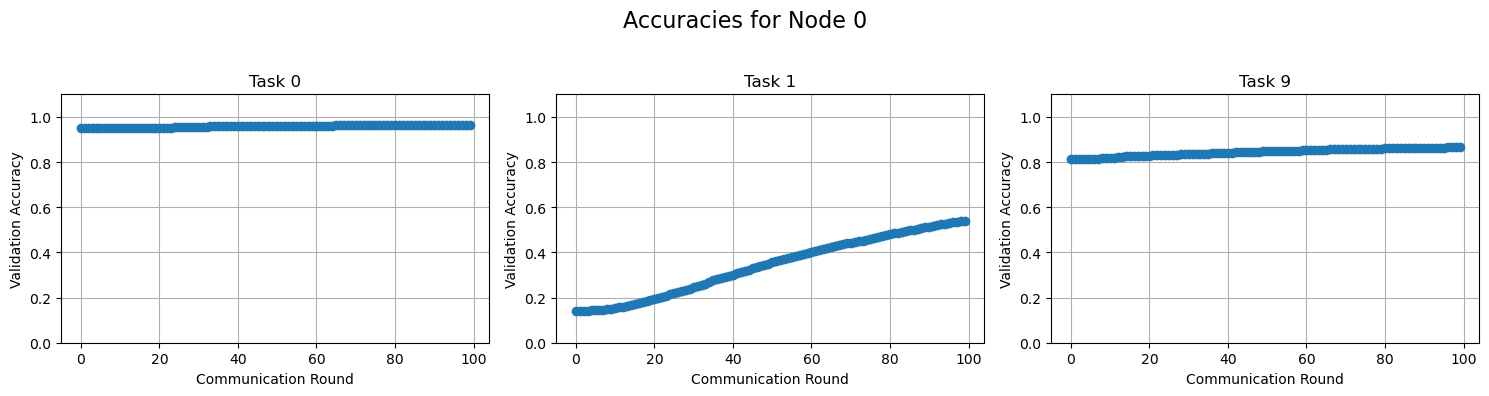

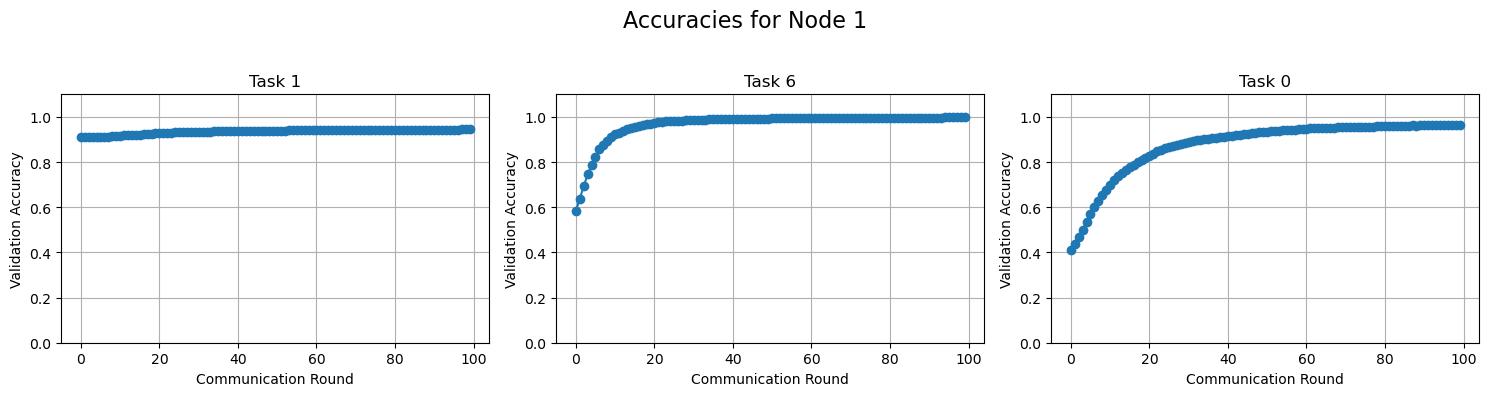

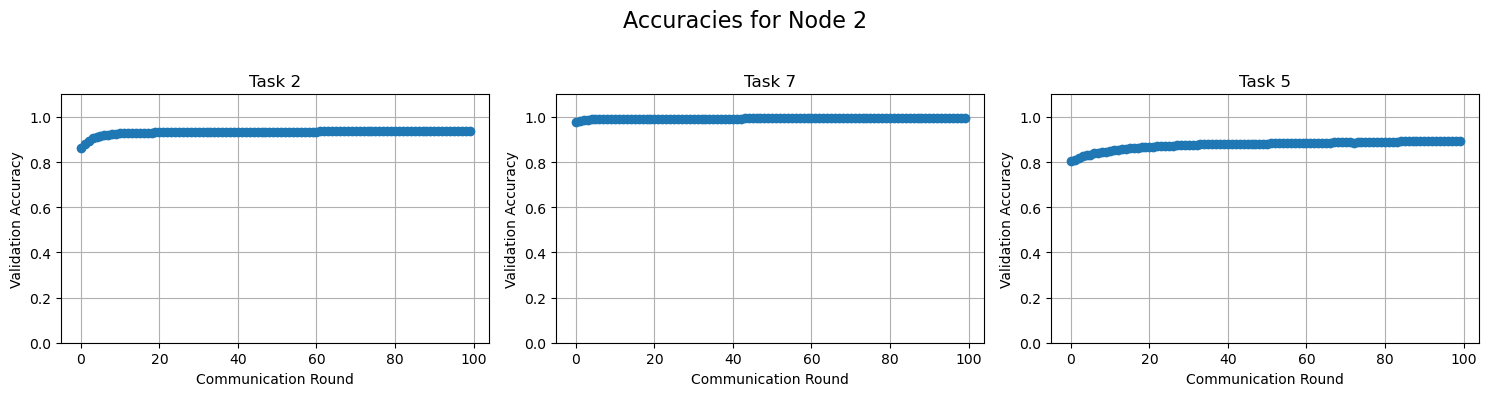

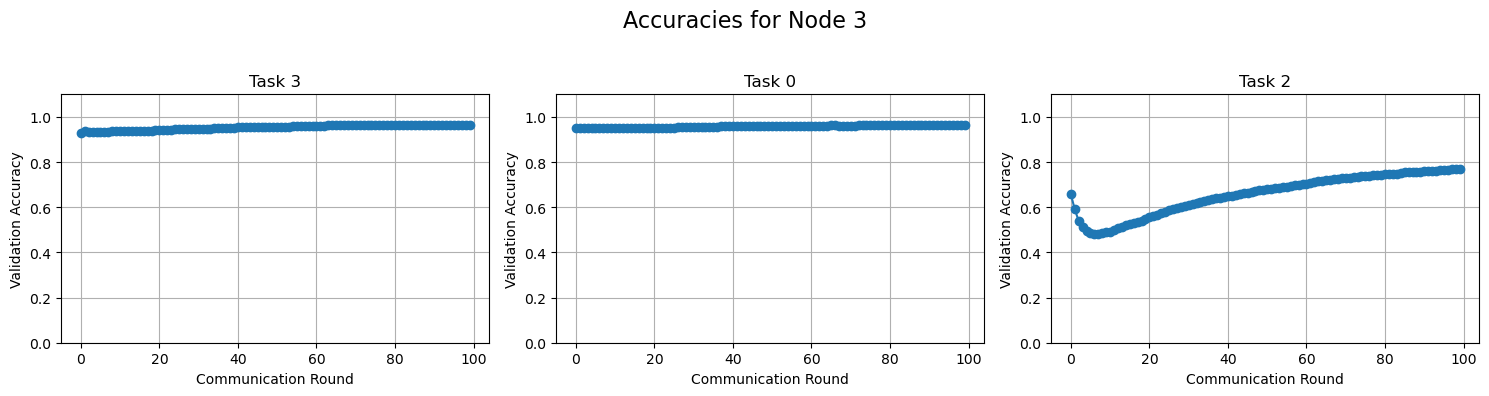

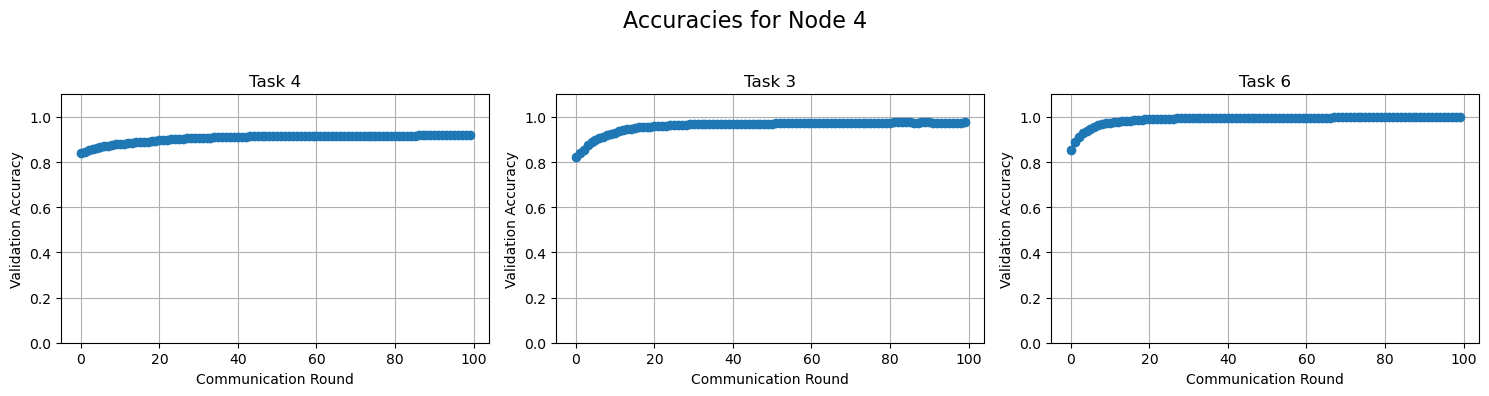

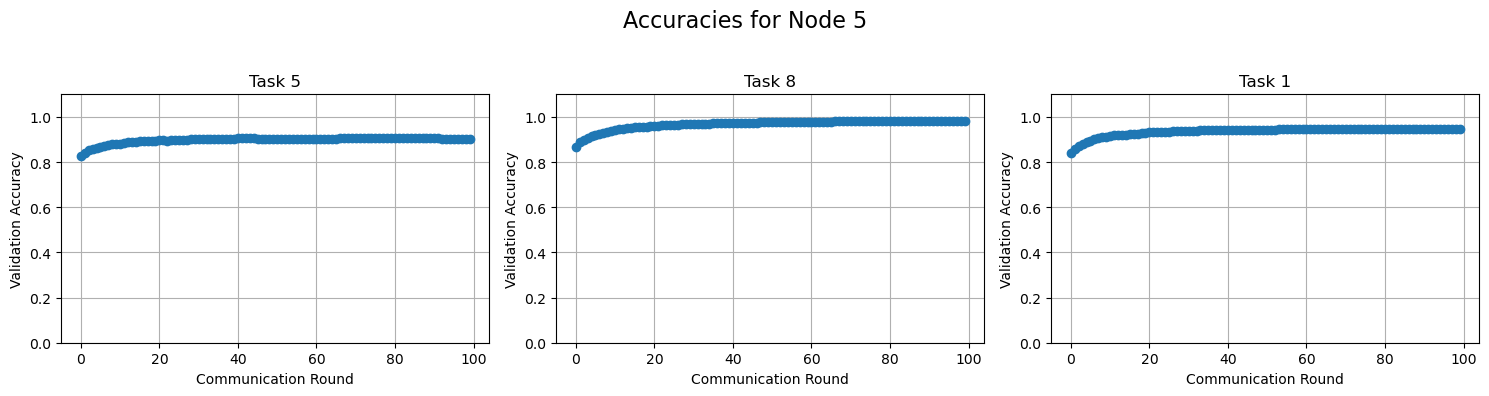

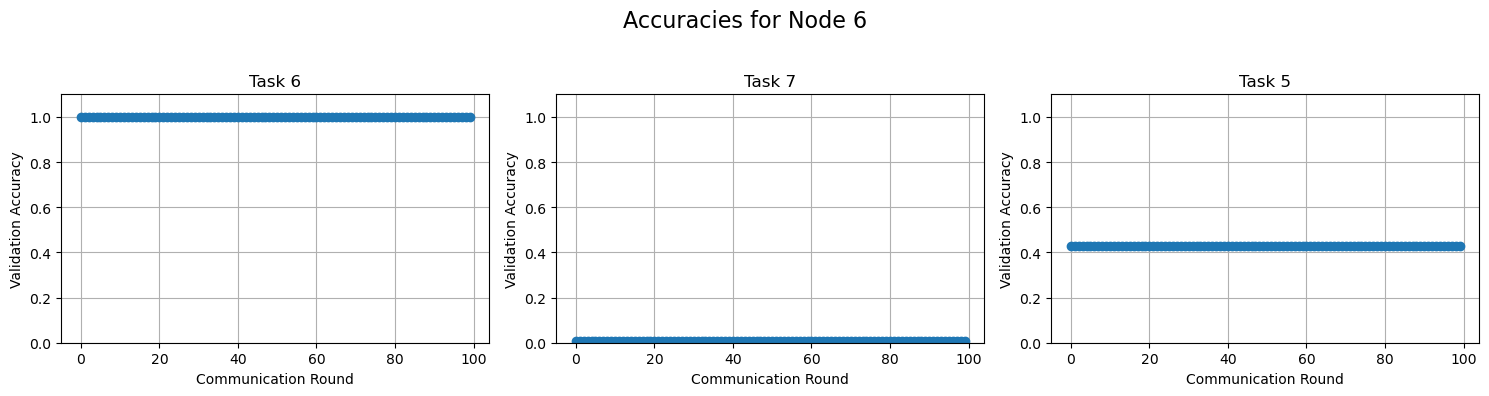

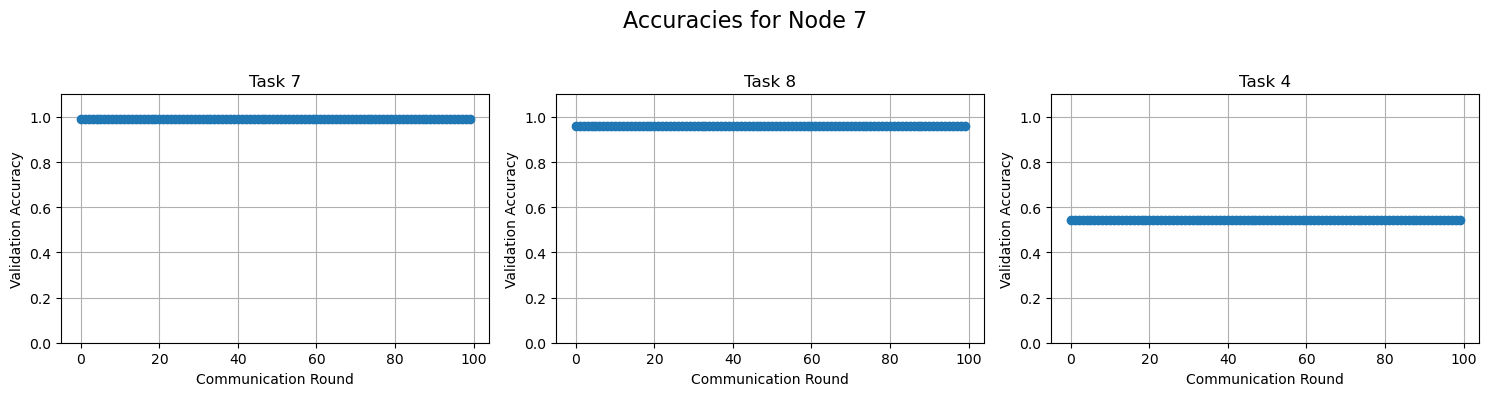

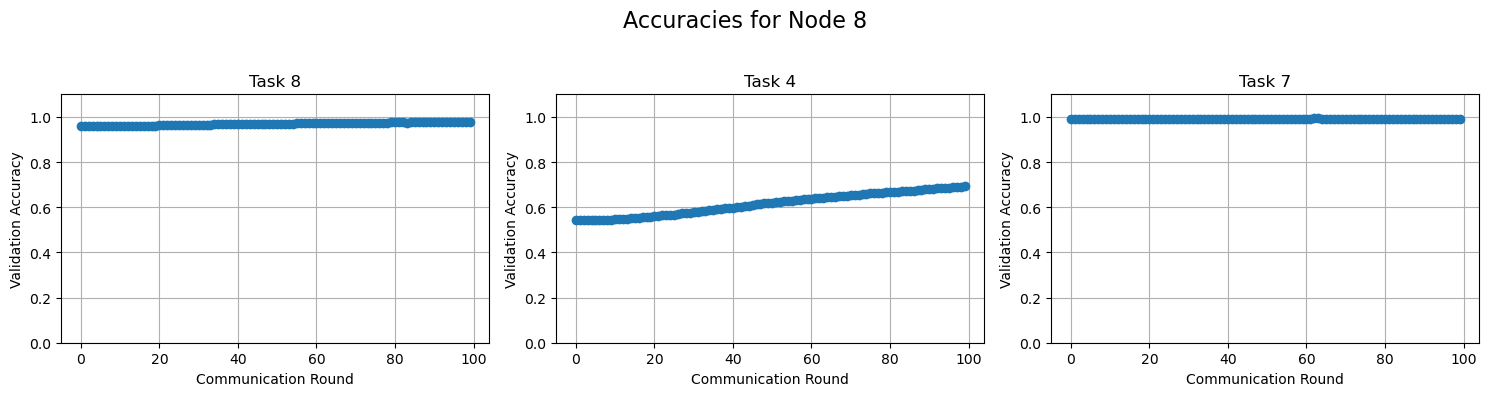

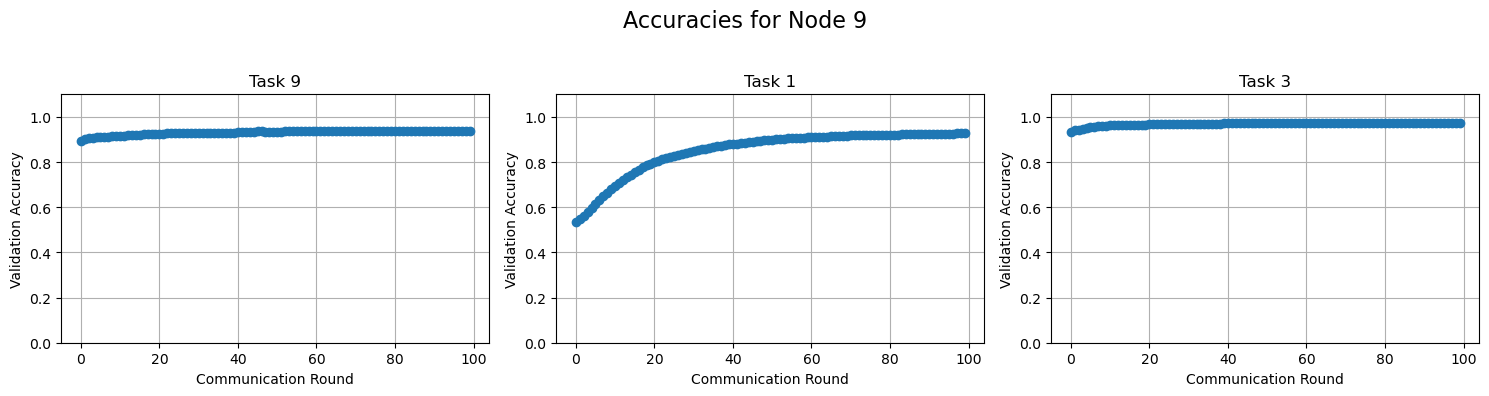

In [791]:
#Local

# Example data: 5 lists, each containing 3 sublists representing accuracies over time
all_accuracies = [accuracy_groups_local[i] for i in range(num_clusters)]

# Create a figure for each list of accuracies
for i, accuracy_list in enumerate(all_accuracies, start=1):
    num_sublists = len(accuracy_list)
    
    # Create subplots for the current list
    fig, axes = plt.subplots(1, num_sublists, figsize=(5 * num_sublists, 4))
    fig.suptitle(f'Accuracies for Node {i-1}', fontsize=16)

    for j, accuracies in enumerate(accuracy_list):
        axes[j].plot(accuracies, marker='o', linestyle='-')
        axes[j].set_title(f'Task {task_assignments[i-1][j]}')
        axes[j].set_xlabel('Communication Round')
        axes[j].set_ylabel('Validation Accuracy')
        axes[j].set_ylim(0, 1.1)
        axes[j].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()


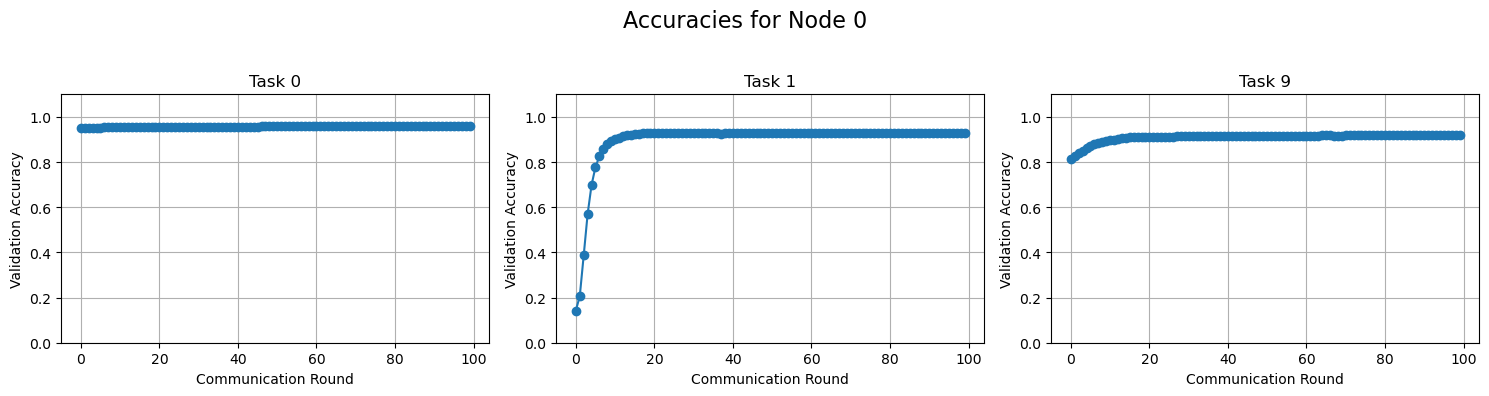

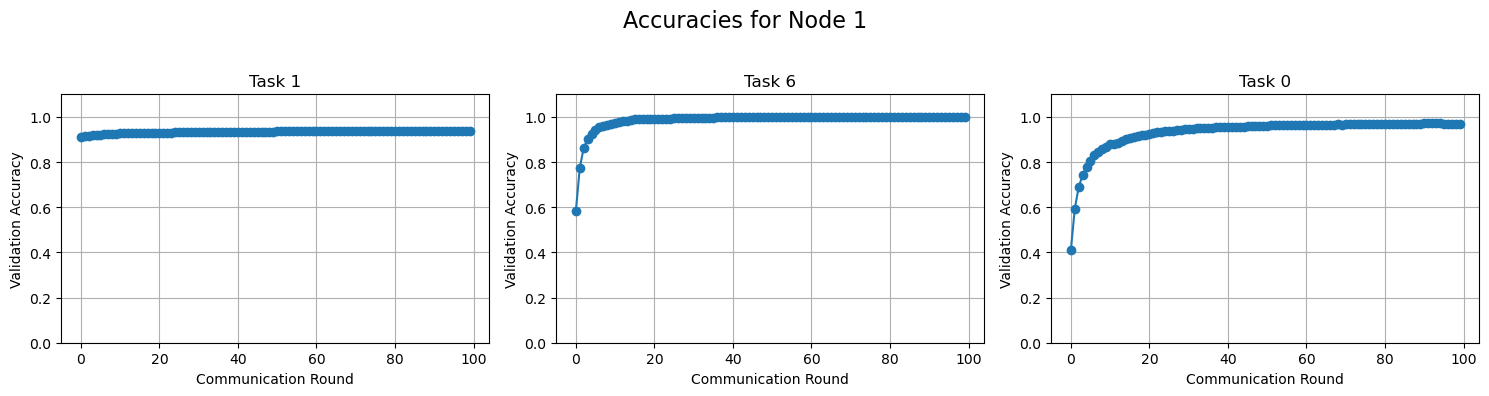

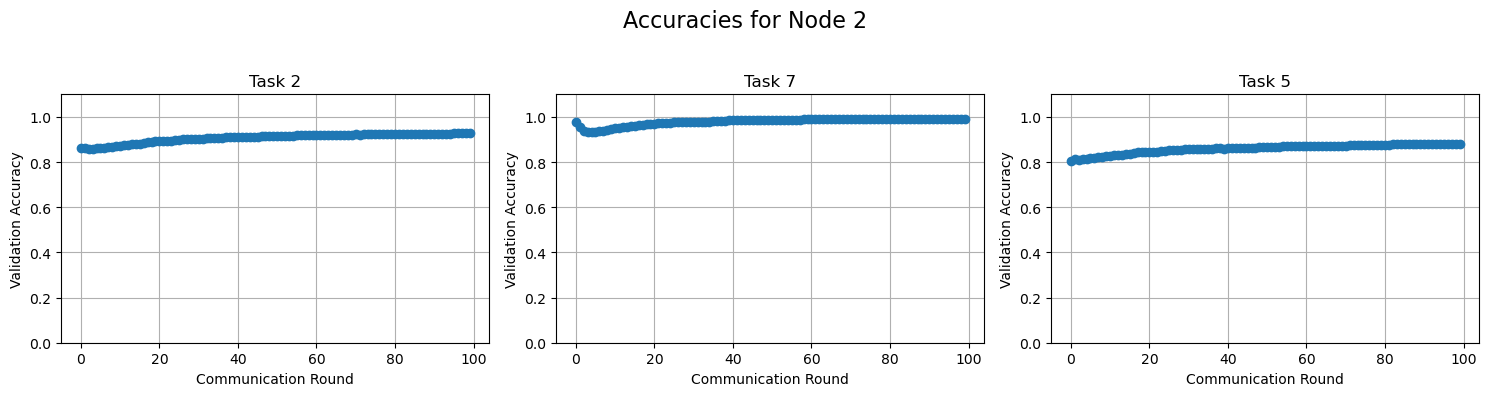

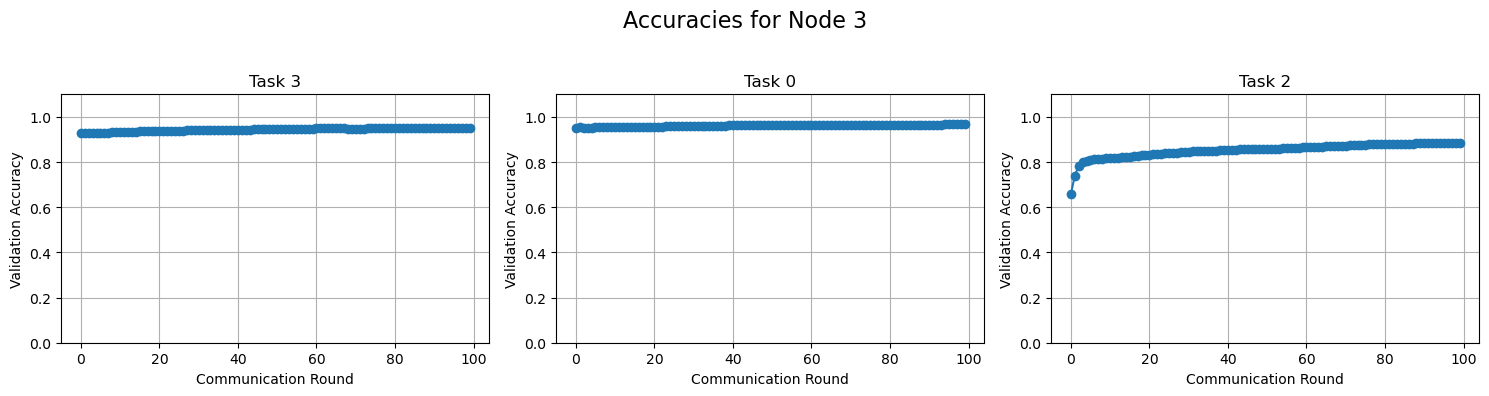

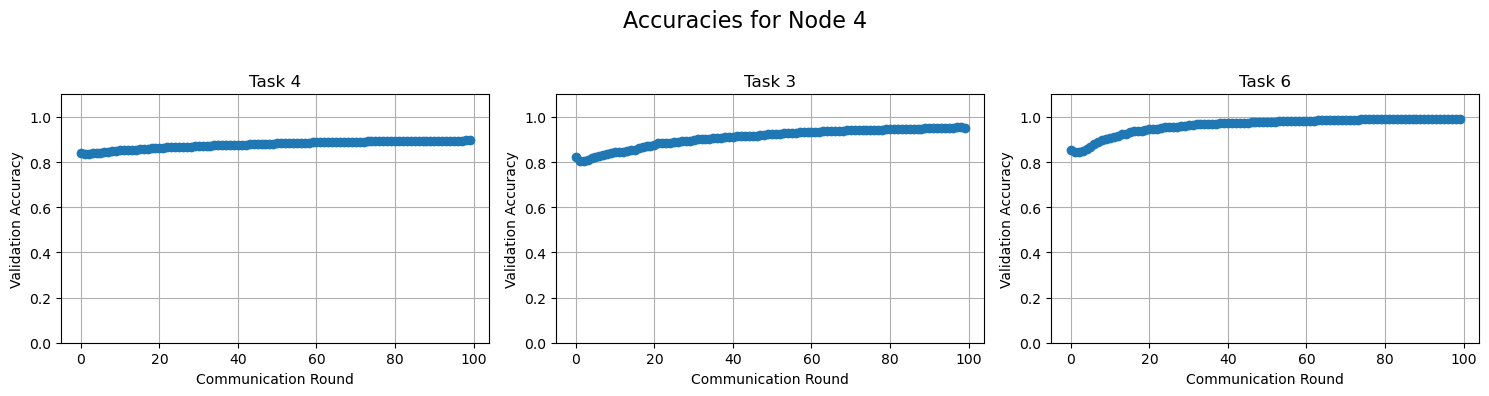

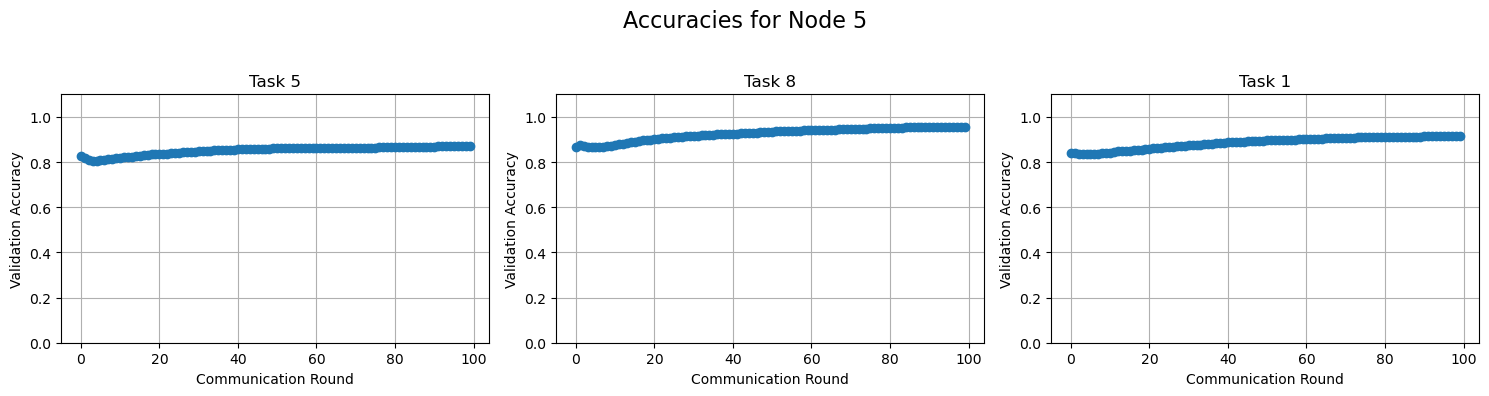

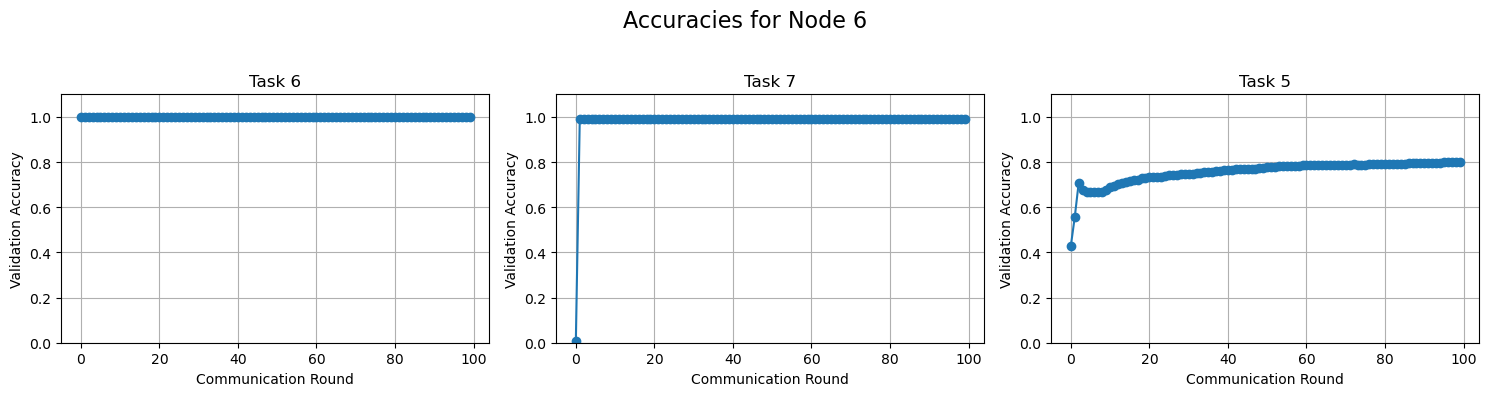

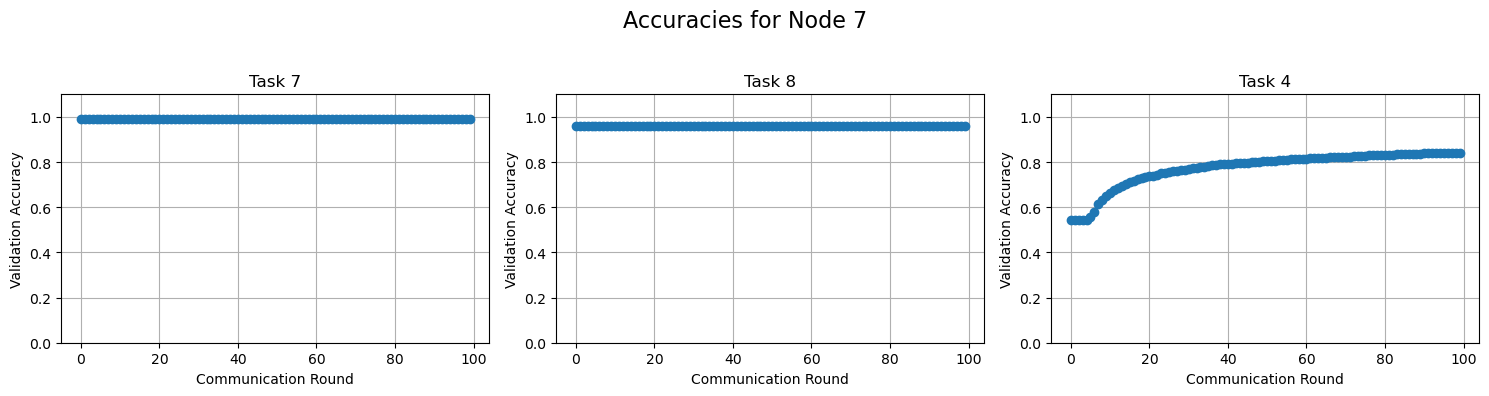

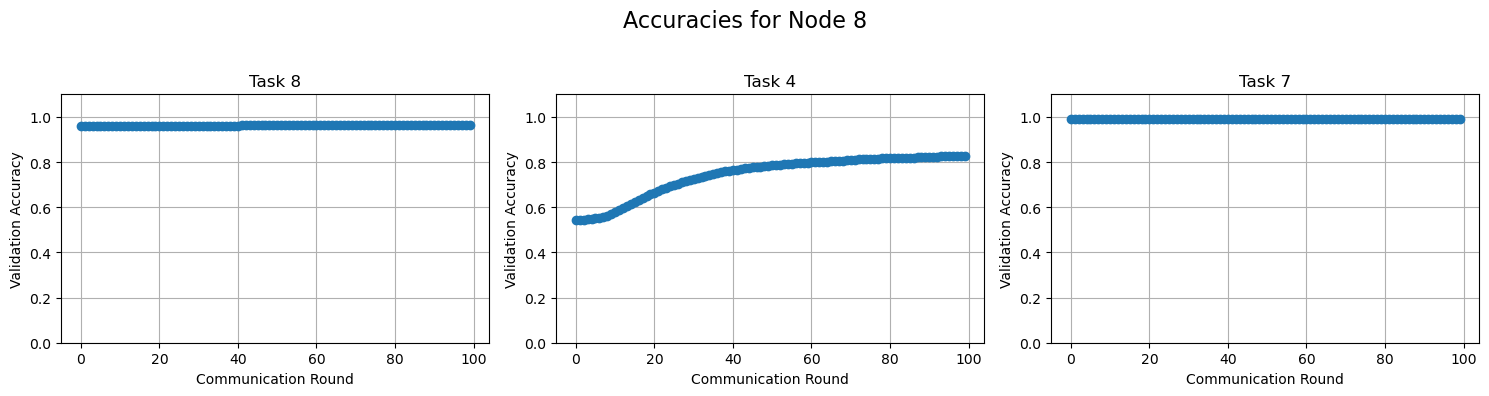

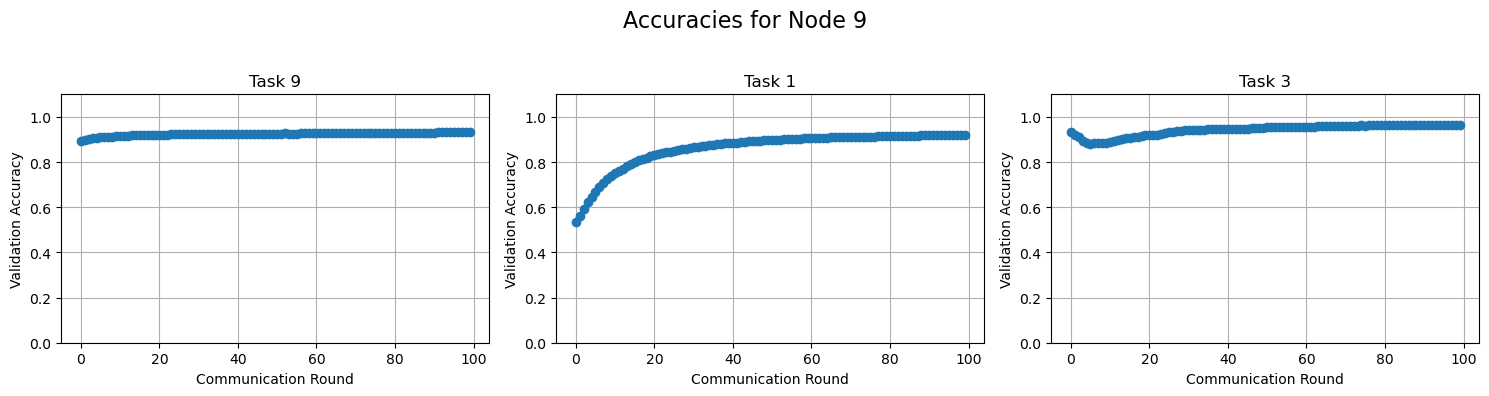

In [792]:
#constant Distillation Collab

# Example data: 5 lists, each containing 3 sublists representing accuracies over time
all_accuracies = [accuracy_groups_collab_constant[i] for i in range(num_clusters)]

# Create a figure for each list of accuracies
for i, accuracy_list in enumerate(all_accuracies, start=1):
    num_sublists = len(accuracy_list)
    
    # Create subplots for the current list
    fig, axes = plt.subplots(1, num_sublists, figsize=(5 * num_sublists, 4))
    fig.suptitle(f'Accuracies for Node {i-1}', fontsize=16)

    for j, accuracies in enumerate(accuracy_list):
        axes[j].plot(accuracies, marker='o', linestyle='-')
        axes[j].set_title(f'Task {task_assignments[i-1][j]}')
        axes[j].set_xlabel('Communication Round')
        axes[j].set_ylabel('Validation Accuracy')
        axes[j].set_ylim(0, 1.1)
        axes[j].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

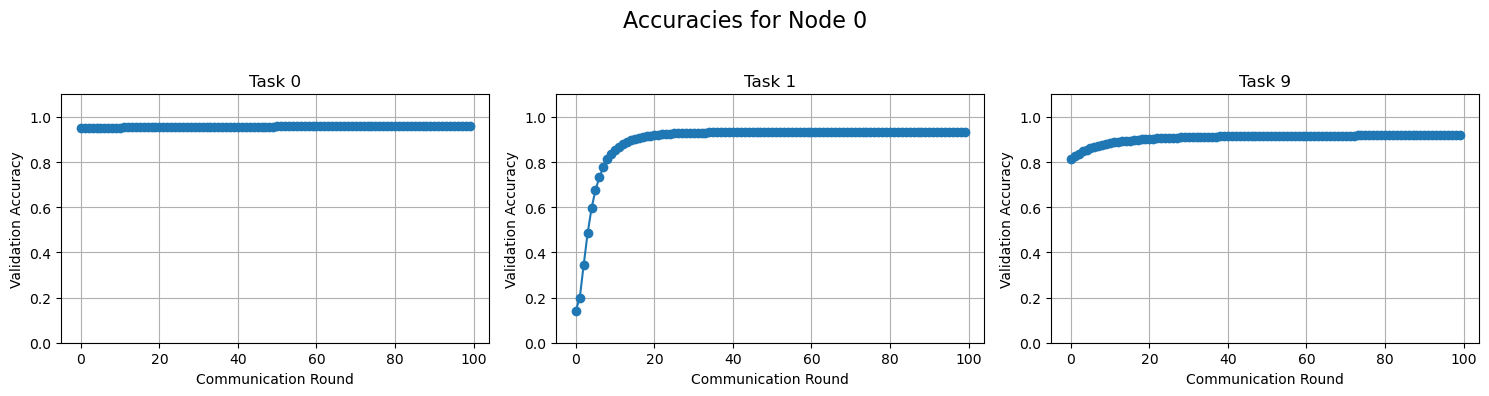

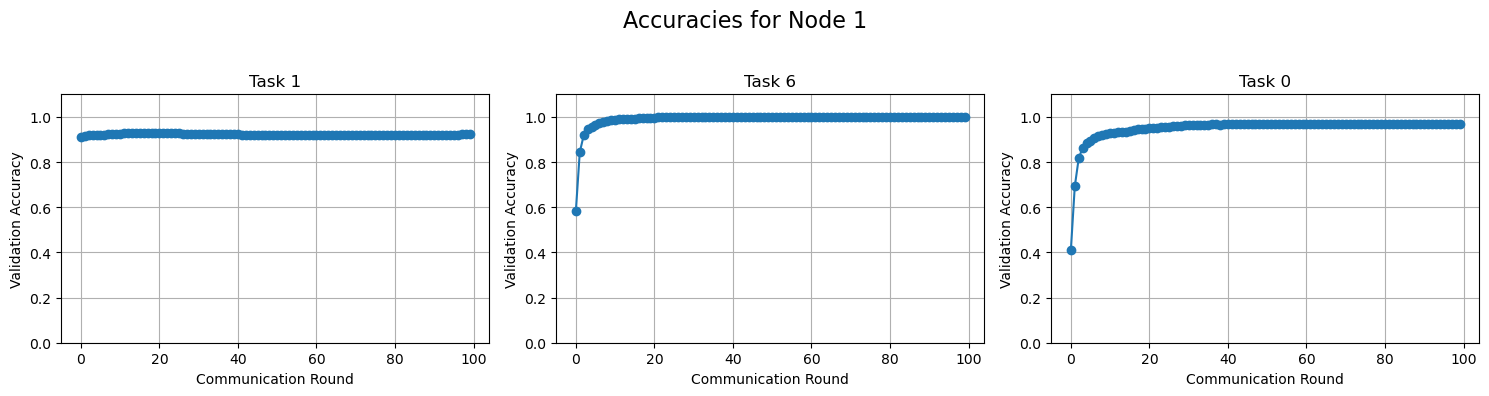

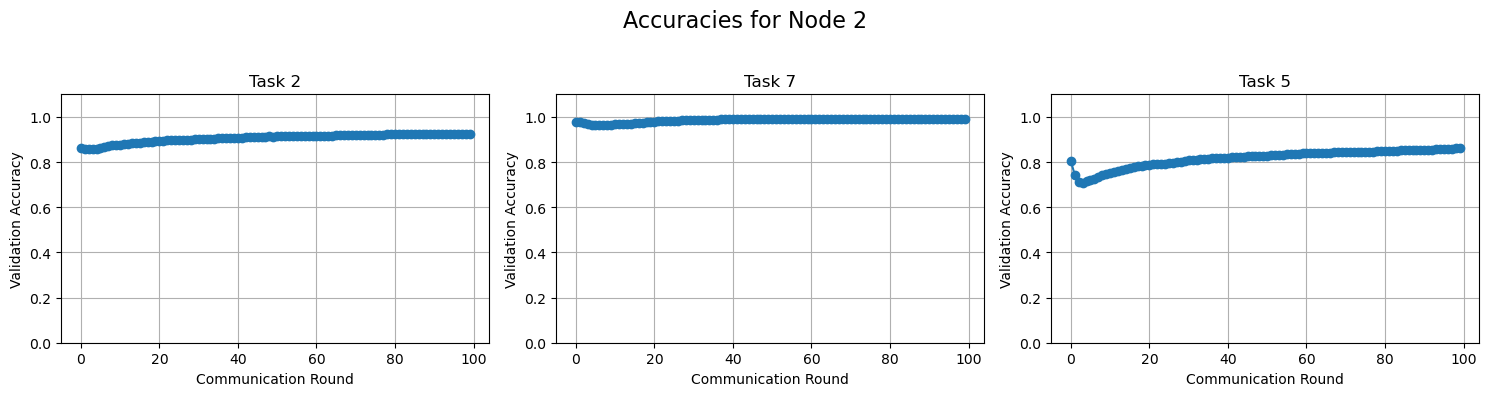

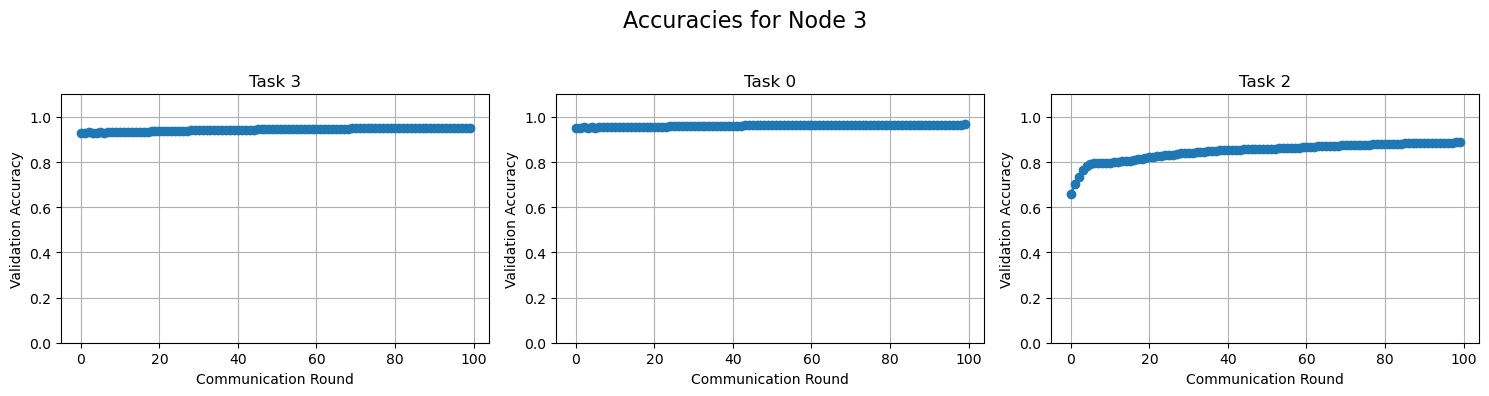

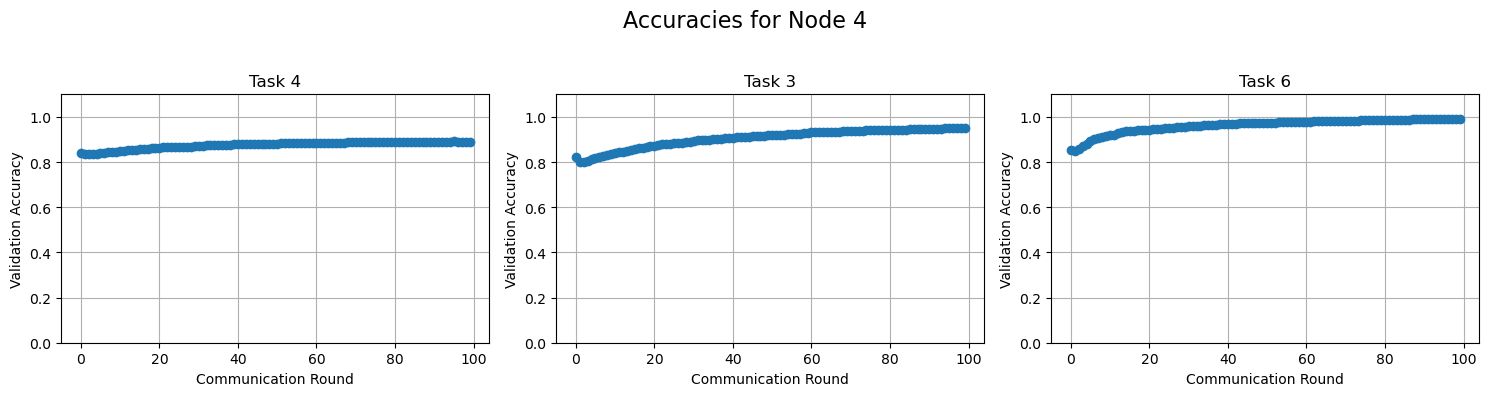

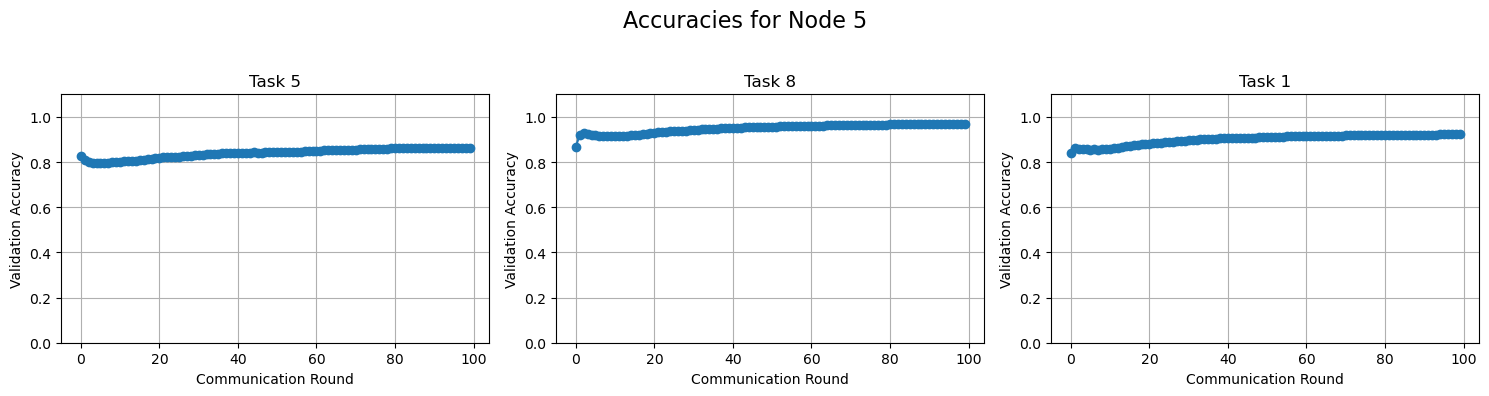

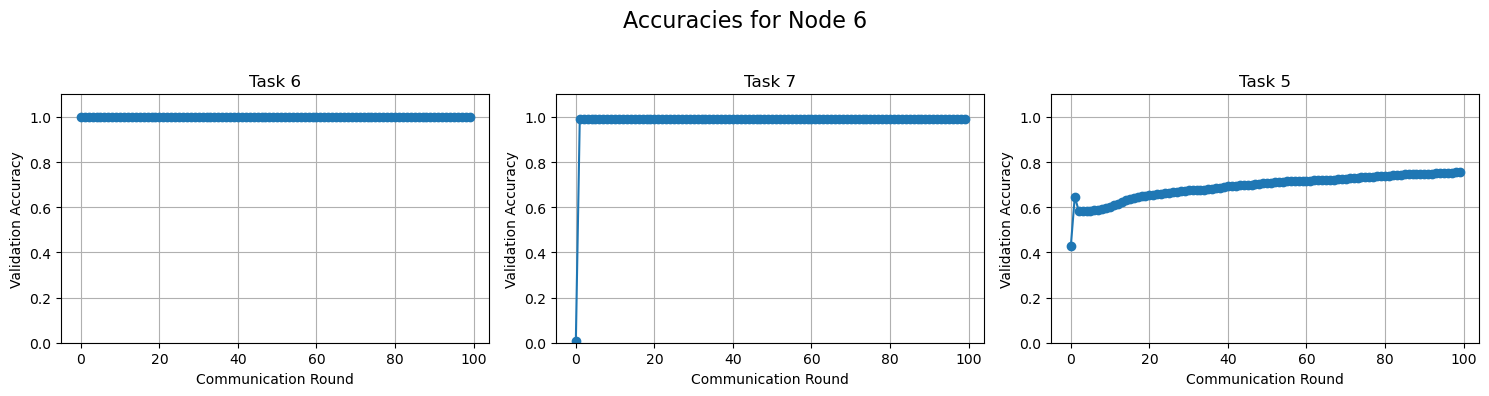

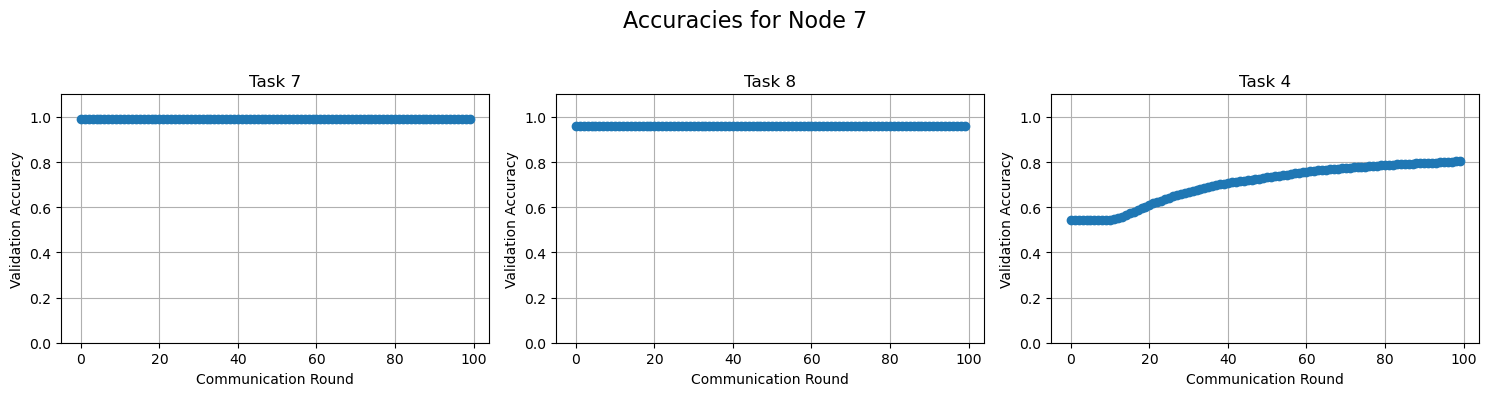

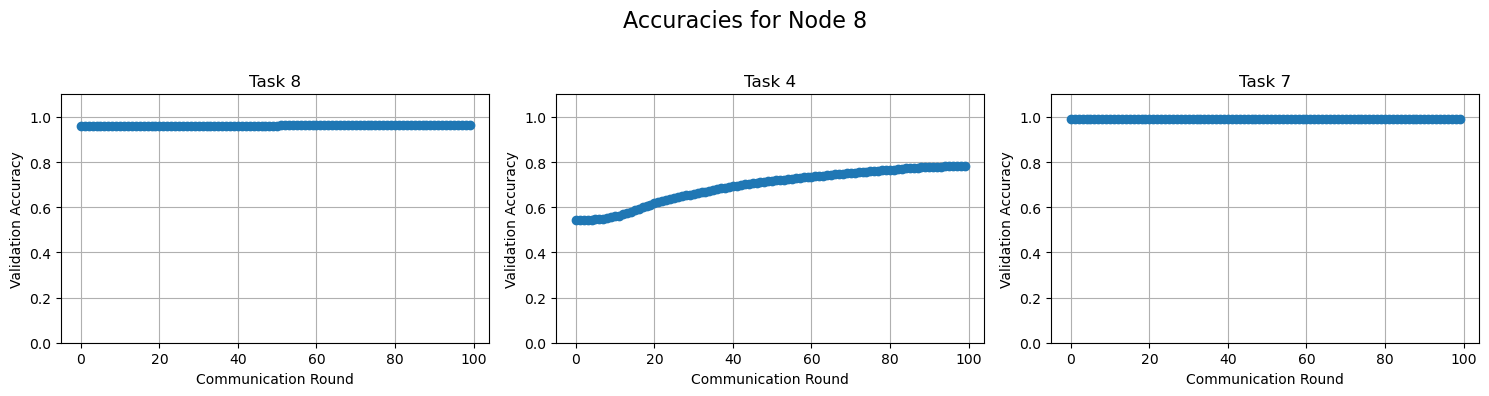

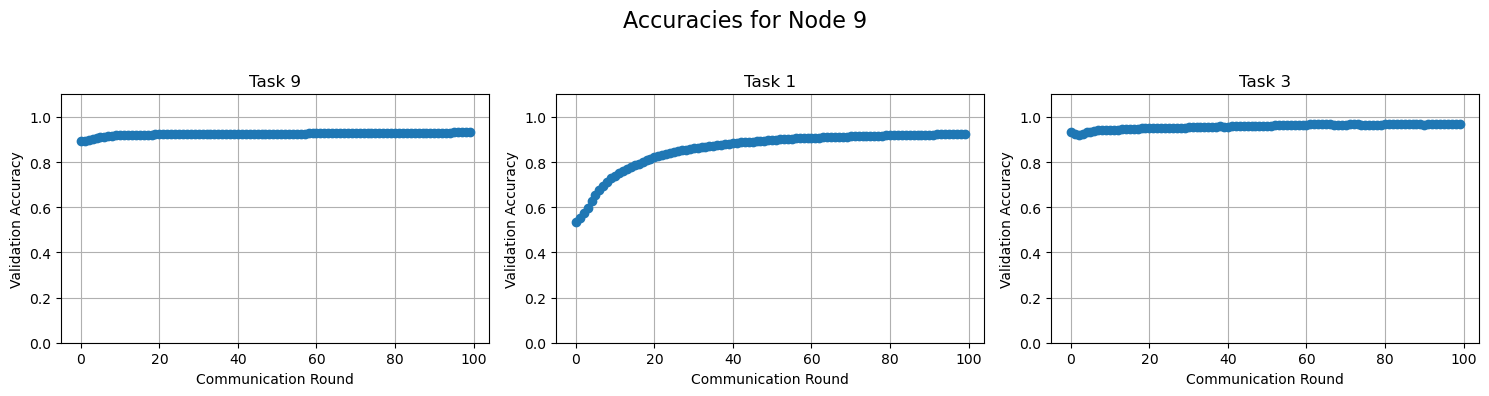

In [793]:
# f(H) distillation collab
# Example data: 5 lists, each containing 3 sublists representing accuracies over time
all_accuracies = [accuracy_groups_collab[i] for i in range(num_clusters)]


# Create a figure for each list of accuracies
for i, accuracy_list in enumerate(all_accuracies, start=1):
    num_sublists = len(accuracy_list)
    
    # Create subplots for the current list
    fig, axes = plt.subplots(1, num_sublists, figsize=(5 * num_sublists, 4))
    fig.suptitle(f'Accuracies for Node {i-1}', fontsize=16)

    for j, accuracies in enumerate(accuracy_list):
        axes[j].plot(accuracies, marker='o', linestyle='-')
        axes[j].set_title(f'Task {task_assignments[i-1][j]}')
        axes[j].set_xlabel('Communication Round')
        axes[j].set_ylabel('Validation Accuracy')
        axes[j].set_ylim(0, 1.1)
        axes[j].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()